In [1]:
from transformers import BertConfig
from gnn import GNNTrainer
from movie_lens_loader import MovieLensLoader
from llm import PromptBertClassifier, VanillaBertClassifier, AddingEmbeddingsBertClassifierBase,mean_over_ranges

import itertools

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
from torch.utils.data import DataLoader
import networkx as nx

In [2]:
config = BertConfig.from_pretrained("google/bert_uncased_L-2_H-128_A-2")
KGE_DIMENSION_PROMPT = 4
KGE_DIMENSION_ADDING = 128
KGE_DIMENSIONS = [KGE_DIMENSION_PROMPT, KGE_DIMENSION_ADDING] # Output Dimension of the GNN Encoder.
model_max_length = 256
movie_lens_loader = MovieLensLoader(kge_dimensions = KGE_DIMENSIONS)
gnn_trainer_prompt =    GNNTrainer(movie_lens_loader.data, kge_dimension = KGE_DIMENSION_PROMPT)
gnn_trainer_prompt.get_embeddings(movie_lens_loader)
gnn_trainer_adding =    GNNTrainer(movie_lens_loader.data, hidden_channels=KGE_DIMENSION_ADDING, kge_dimension = KGE_DIMENSION_ADDING)
gnn_trainer_adding.get_embeddings(movie_lens_loader)
vanilla_bert_only_classifier = VanillaBertClassifier(movie_lens_loader.llm_df,model_max_length = model_max_length)
dataset_vanilla = movie_lens_loader.generate_vanilla_dataset(vanilla_bert_only_classifier.tokenize_function)
prompt_bert_only_classifier = PromptBertClassifier(movie_lens_loader, gnn_trainer_prompt.get_embedding, kge_dimension=gnn_trainer_prompt.kge_dimension, batch_size=64,model_max_length = model_max_length)
dataset_prompt = movie_lens_loader.generate_prompt_embedding_dataset(prompt_bert_only_classifier.tokenize_function, kge_dimension = prompt_bert_only_classifier.kge_dimension)
adding_embedding_bert_only_classifier = AddingEmbeddingsBertClassifierBase(movie_lens_loader, gnn_trainer_adding.get_embedding, kge_dimension=config.hidden_size, batch_size=64,model_max_length = model_max_length)
dataset_adding_embedding = movie_lens_loader.generate_adding_embedding_dataset(adding_embedding_bert_only_classifier.tokenizer.sep_token, adding_embedding_bert_only_classifier.tokenizer.pad_token, adding_embedding_bert_only_classifier.tokenize_function, kge_dimension = config.hidden_size)

loading pretrained model
Device: 'cpu'
loading pretrained model
Device: 'cpu'


In [49]:
def mean_over_ranges(tens: torch.Tensor, starts: torch.Tensor, ends: torch.Tensor) -> torch.Tensor:
    '''
    This operation allows to produce a mean over ranges of different sizes in torch tensor manner only.
    We use padding positions to calculate an average and then remove the padded positions afterwards.
    This code was based on ChatGPT suggestions and works on the assumption:
    Let S be the sum of the padded list of numbers.
    Let n be the number of elements in the padded list.
    Let μ be the average of the padded list of numbers.
    Let r be the difference between the actual range lengths and the max range length 
    Let x be the number that is at the padding position.
    μ' = ((μ * n)-(r * x)) / (n - r)
    '''
    # input: # ends: torch.tensor([2, 5, 6]) starts: tensor([0, 2, 4])
    # Compute the maximum length of the ranges
    max_length = (ends - starts).max()
    range_diffs = (max_length - (ends-starts)).unsqueeze(1) # the amount of times, the range had to be padded 
    # Create a range tensor from 0 to max_length-1
    range_tensor = torch.arange(max_length).unsqueeze(0)

    # Compute the ranges using broadcasting and masking
    ranges = starts.unsqueeze(1) + range_tensor
    mask = ranges < ends.unsqueeze(1)

    # Apply the mask
    result = ranges * mask  # result: tensor([[0, 1, 0], [2, 3, 4], [4, 5, 0]]) here padding index is 0
                            #                        -                     -    positions were padded
    result = result.unsqueeze(dim = 2).repeat(1,1, tens.shape[2])
    gather = tens.gather(dim = 1, index = result)
    means = torch.mean(gather, dim = 1) # The mean was computed with the padding positions. We will remove the values from the mean now,
    values_to_remove = range_diffs * tens[:,0] # the summed value at padded position
    actual_means = (means * max_length - values_to_remove) / (max_length - range_diffs) # the actual mean without padding positions
    return actual_means

def forward_dataset_and_save_outputs(self: VanillaBertClassifier, dataset, split = "val", batch_size = 64, epochs = 3, force_recompute = False):
    self.model.eval()
    data_collator = self._get_data_collator(split)
    last_hidden_states = []
    all_attentions = []
    all_ranges_over_batch = []
    #for epoch in range(epochs):
    if True:
        data_loader = DataLoader(dataset=dataset[split], batch_size= batch_size, collate_fn = data_collator)
        #for idx, batch in enumerate(data_loader):
        for idx in range(2):
            batch = next(iter(data_loader))
            with torch.no_grad():
                outputs = self.model(input_ids = batch["input_ids"], attention_mask = batch["attention_mask"], output_hidden_states=True, output_attentions = True)
                hidden_states = outputs.hidden_states
                attentions = outputs.attentions
                last_hidden_states.append(hidden_states[-1])
                ranges_over_batch = self._get_ranges_over_batch(batch["input_ids"])
                all_ranges_over_batch.append(ranges_over_batch)
                all_attentions.append(torch.stack([torch.sum(attention, dim=1).detach() for attention in attentions]))
    # Concatenate all hidden states across batches
    last_hidden_states = torch.cat(last_hidden_states)
    all_ranges_over_batch = torch.cat(all_ranges_over_batch)
    all_attentions = [layer.reshape(-1, layer.shape[2], layer.shape[3]) for layer in all_attentions]
    print(len(all_attentions), all_attentions[0].shape)
    averaged_hidden_states = []
    for position in range(all_ranges_over_batch.shape[1]):
        ranges_over_batch = all_ranges_over_batch[:,position]
        starts = ranges_over_batch[:,0]
        ends = ranges_over_batch[:,1]
        averaged_hidden_states.append(mean_over_ranges(last_hidden_states, starts, ends))
    averaged_hidden_states = torch.stack(averaged_hidden_states)
    averaged_hidden_states =averaged_hidden_states.reshape(averaged_hidden_states.shape[1], averaged_hidden_states.shape[0], -1)
    return averaged_hidden_states

forward_dataset_and_save_outputs(vanilla_bert_only_classifier, dataset_vanilla).shape

2 torch.Size([128, 256, 256])


torch.Size([128, 3, 128])

In [58]:


tens = torch.rand((3,6))
# Example start and end tensors
starts = torch.tensor([0, 2, 4])
ends = torch.tensor([2, 5, 6])
print(tens)
print(starts)
print(ends)
print(mean_over_ranges(tens, starts, ends))

#implementation with python loops:
result = torch.zeros(len(tens))
for pos, (ten, start, end) in enumerate(zip(tens, starts, ends)):
    range_ = torch.arange(start, end)
    result[pos] = torch.mean(ten[range_])
print(result)

tensor([[0.7034, 0.8463, 0.3901, 0.8869, 0.8578, 0.5480],
        [0.8098, 0.4896, 0.9325, 0.2215, 0.8933, 0.2760],
        [0.6368, 0.4093, 0.8405, 0.6394, 0.4869, 0.2798]])
tensor([0, 2, 4])
tensor([2, 5, 6])
tensor([0.7748, 0.6824, 0.3833])
tensor([0.7748, 0.6824, 0.3833])


In [4]:
vanilla_attention_matrix, vanilla_attention_matrix_normalized = vanilla_bert_only_classifier.generate_semantic_attention_matrix(dataset_vanilla)
prompt_attention_matrix, prompt_attention_matrix_normalized = prompt_bert_only_classifier.generate_semantic_attention_matrix(dataset_prompt)
adding_embedding_attention_matrix, adding_embedding_attention_matrix_normalized = adding_embedding_bert_only_classifier.generate_semantic_attention_matrix(dataset_adding_embedding)

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


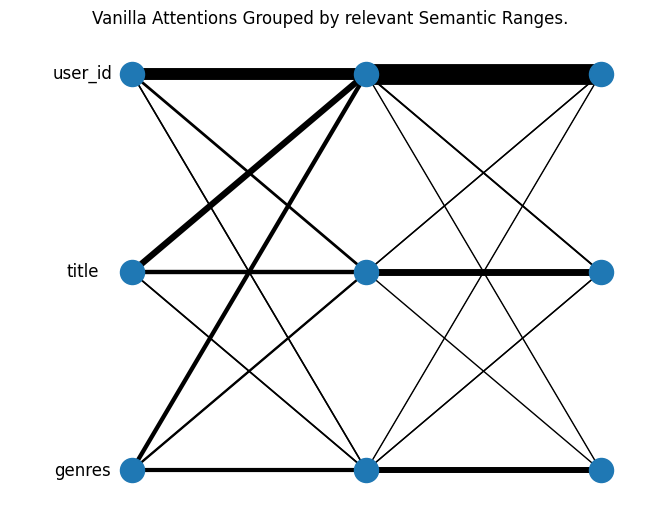

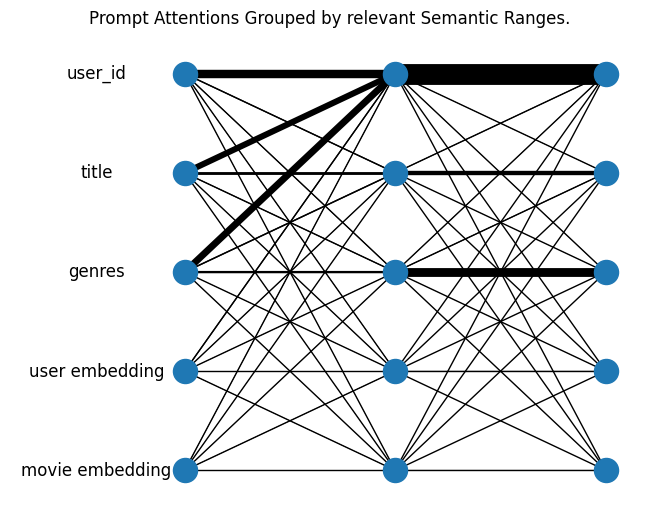

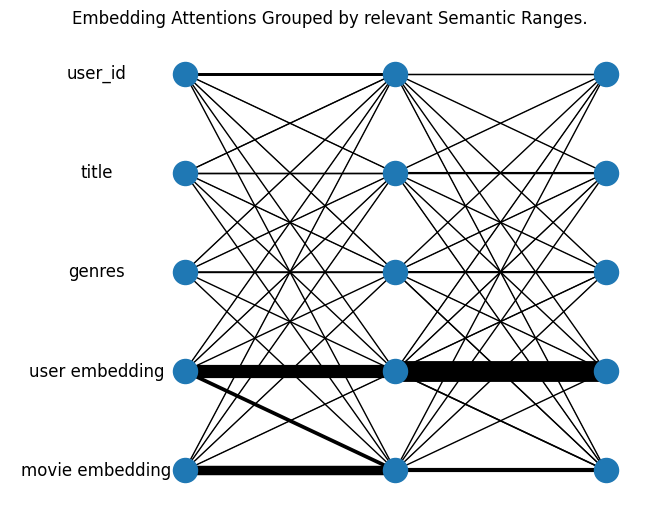

In [8]:
vanilla_bert_only_classifier.plot_attention_graph(vanilla_attention_matrix, "Vanilla Attentions Grouped by relevant Semantic Ranges.")
prompt_bert_only_classifier.plot_attention_graph(prompt_attention_matrix, "Prompt Attentions Grouped by relevant Semantic Ranges.")
adding_embedding_bert_only_classifier.plot_attention_graph(adding_embedding_attention_matrix, "Embedding Attentions Grouped by relevant Semantic Ranges.")

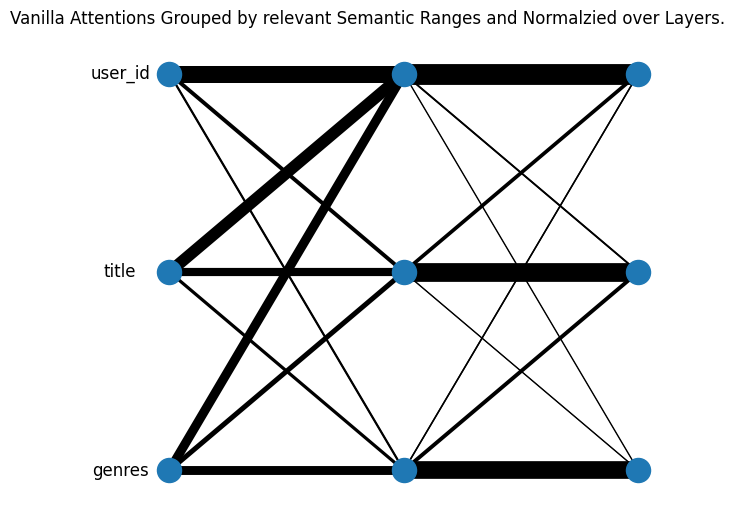

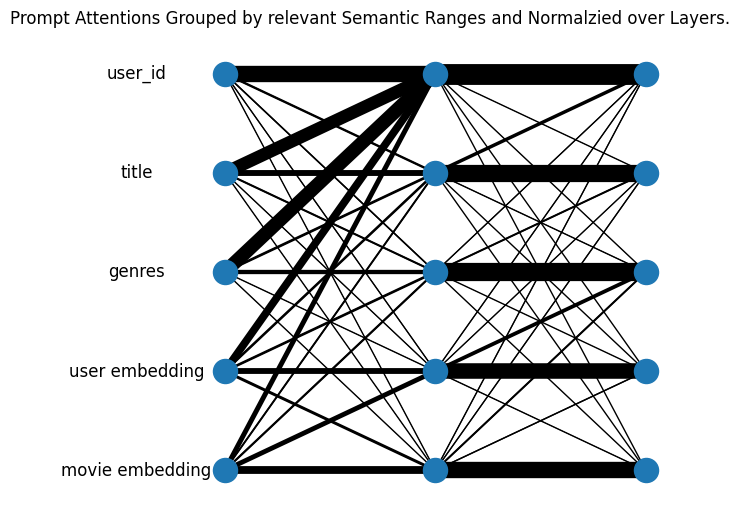

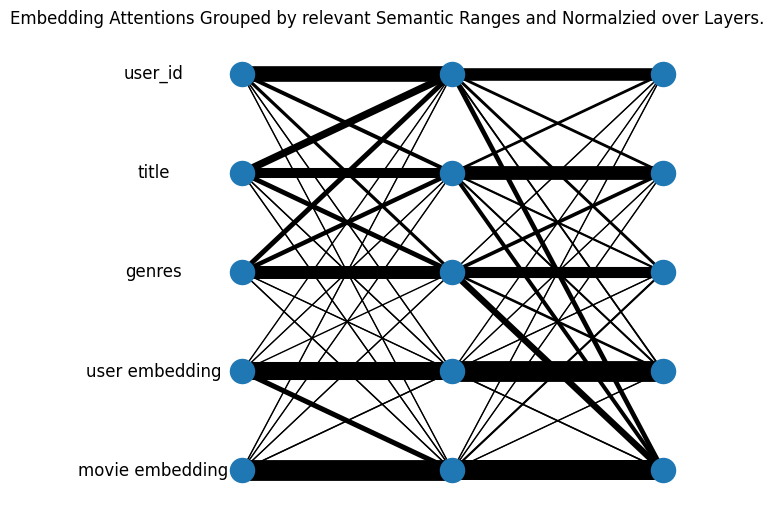

In [9]:
vanilla_bert_only_classifier.plot_attention_graph(vanilla_attention_matrix_normalized, "Vanilla Attentions Grouped by relevant Semantic Ranges and Normalzied over Layers.")
prompt_bert_only_classifier.plot_attention_graph(prompt_attention_matrix_normalized, "Prompt Attentions Grouped by relevant Semantic Ranges and Normalzied over Layers.")
adding_embedding_bert_only_classifier.plot_attention_graph(adding_embedding_attention_matrix_normalized, "Embedding Attentions Grouped by relevant Semantic Ranges and Normalzied over Layers.")